# Information extraction pipelines

Connect with Google Drive to load the files

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/Othercomputers/Mi portátil/GroupProject"

/content/drive/Othercomputers/Mi portátil/GroupProject


Install the required libraries

In [ ]:
pip install pdfplumber sentence-transformers faiss-cpu transformers pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/5

# Approach 1:

1) Divide the full text into chunks (Artículos)

2) Calculate the embedding for each chunk

3) Define the different queries

4) Obtain the embedding of each query

5) For each query, get the 3 most similar chunks (based on L2 similarity)

6) Ask query to the QA model, with the 3 chunks as context.

7) Create the CSV with the different responses from the QA model.


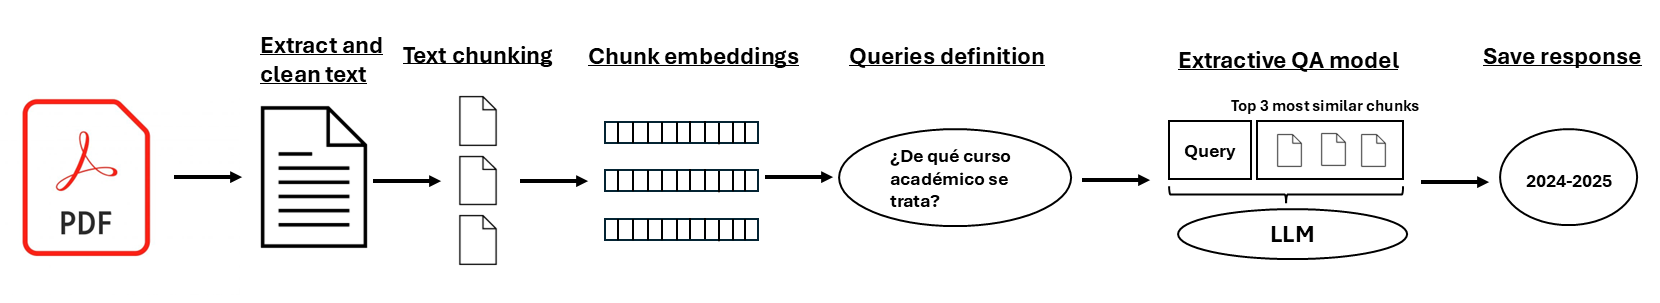

## Divide the full PDF into smaller chunks (Artículos)

We are going to define a function that, given a PDF, it divides into its different 'Artículos':

In [ ]:
import re
import pdfplumber

# Function to clean text
def clean_text(text):
    # 1. Eliminar el bloque sucio que empieza con "\nCSV" y termina antes de "\nCAPÍTULO"
    text = re.sub(r"\nCSV.*?(?=ogidóC)", "", text, flags=re.DOTALL)
    text = re.sub(r"ogidóC", "", text, flags=re.IGNORECASE)

    # 3. Sustituir saltos de línea por un espacio
    text = text.replace("\n", " ")

    # 4. Eliminar múltiples espacios
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Function to extract artículos from the whole PDF
def extract_articulos_to_dict(pdf_path):
  # Regex to match "Artículo X." or "Artículo X" (with optional punctuation)
  # Added handling for numbers followed by "." or other separators
  articulo_pattern = re.compile(r'Artículo\s+(\d+)[\.\s]')  # Matches "Artículo 2." or "Artículo 2 "
  articulos_dict = {}
  current_articulo = None
  current_text = []

  with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
      text = page.extract_text()
      if not text:
        continue

      # Split text into lines to handle multi-line headers
      lines = text.split('\n')
      for line in lines:
        # Check for "Artículo X" in the line
        match = articulo_pattern.match(line.strip())  # Use .match() for start-of-line
        if match:
          # Save previous article (if exists)
          if current_articulo:
              articulos_dict[current_articulo] = "\n".join(current_text)
              current_text = []

          # Start new article
          articulo_number = match.group(1)
          current_articulo = f"Artículo {articulo_number}"

          # Add the rest of the line (after "Artículo X") to the current article
          remaining_text = line.split(match.group(0), 1)[-1].strip()
          if remaining_text:
            current_text.append(remaining_text)
        else:
          # Append to current article
          if current_articulo:
            current_text.append(line.strip())

  # Add the last article
  if current_articulo and current_text:
    articulos_dict[current_articulo] = "\n".join(current_text)

  # Clean the chunks
  clean_articulos_dict = {}
  for key, value in articulos_dict.items():
    clean_articulos_dict[key] = clean_text(value)

  return clean_articulos_dict

## Convert text chunks (each artículo) into embeddings

In [ ]:
def create_faiss_index(text_chunks):
  # Get the values (text content) from the dictionary
  text_list = list(text_chunks.values())
  embeddings = embedding_model.encode(text_list)  # Convert text to vectors
  index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 similarity search
  index.add(np.array(embeddings, dtype="float32"))
  # Return the index and the original dictionary (text_chunks)
  return index, text_chunks

## Retrieve the most relevant sections from the PDF



In [ ]:
def search_relevant_chunks(query, index, text_chunks, top_k=3):
  query_embedding = embedding_model.encode([query])
  distances, indices = index.search(np.array(query_embedding, dtype="float32"), top_k)
  # Get the keys of the text_chunks dictionary
  keys = list(text_chunks.keys())
  # Use the indices to get the corresponding keys and then retrieve the values
  return [text_chunks[keys[i]] for i in indices[0]]

## Question answering from the relevant data:



In [ ]:
def extract_info(question, index, text_chunks):
  relevant_texts = search_relevant_chunks(question, index, text_chunks)
  context = " ".join(relevant_texts)
  response = qa_model(question=question, context=context)
  return response["answer"] if "answer" in response else "Not Found"

## Pipeline implementation

In [ ]:
import pdfplumber
import faiss
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# Load Embedding and LLM Models
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
qa_model = pipeline("question-answering", model="PlanTL-GOB-ES/roberta-large-bne-sqac")

# Process the PDF and extract structured data
def process_pdf(pdf_path, output_csv):
  # Extract text and create FAISS index
  text_chunks = extract_articulos_to_dict(pdf_path)
  index, text_chunks = create_faiss_index(text_chunks)

  # Define the queries
  questions = {
      "Año académico": "¿Cuál es el curso académico al que corresponde esta convocatoria de becas?",
      "Financiación total": "¿Cuál es el importe total asignado a esta convocatoria de becas?",
      "Niveles no universitarios": "¿Qué niveles de enseñanzas no universitarias están incluidos en esta convocatoria?",
      "Niveles universitarios": "¿Qué niveles de enseñanzas universitarias están cubiertos por esta convocatoria?",
      "Casos especiales": "¿Qué situaciones especiales contempla la convocatoria (como discapacidad, insularidad, etc.)?",
      "Cuantías fijas": "¿Cuáles son los diferentes tipos de cuantías fijas que cubre la beca?",
      "Cuantía fija renta": "¿Cuál es la cuantía fija establecida en función de la renta familiar?",
      "Cuantía fija residencia": "¿Cuál es la cuantía fija que se otorga por gastos de residencia?",
      "Cuantía fija excelencia académica": "¿Cuál es la cuantía fija otorgada por excelencia académica?",
      "Cuantía variable": "¿Cómo se calcula la cuantía variable de la beca y en función de qué factores?",
      "Umbral 1": "¿Cuáles son los valores del umbral 1 para la renta familiar según el número de miembros?",
      "Umbral 2": "¿Cuáles son los valores del umbral 2 para la renta familiar según el número de miembros?",
      "Umbral 3": "¿Cuáles son los valores del umbral 3 para la renta familiar según el número de miembros?",
      "Inicio plazo": "¿Desde cuándo se puede solicitar la beca?",
      "Deadline": "¿Cuál es la fecha límite para presentar la solicitud de beca?",
      "Requisitos año en curso": "¿Qué asignaturas o requisitos debe superar el alumno universitario durante el año en curso?",
      "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": "¿Qué porcentaje de créditos debe haber superado un alumno universitario en el curso anterior para renovar la beca?",
      "Requisitos académicos curso anterior para primer curso universitario": "¿Qué nota se exige en el acceso a la universidad para obtener la beca en primer curso?",
      "Nacionalidad": "¿Qué nacionalidad o condición migratoria se requiere para poder optar a la beca?",
      "Número créditos matrículados": "¿Cuántos créditos debe tener matriculados el estudiante para optar a la beca?",
      "Numero créditos matrícula parcial": "¿Cuántos créditos debe matricular el estudiante en caso de matrícula parcial?",
    }


  # Description for each field
  field_descriptions = {
      "Año académico": "Curso académico de la convocatoria.",
      "Financiación total": "Importe total asignado a la convocatoria de becas.",
      "Niveles no universitarios": "Enseñanzas no universitarias incluidas en la convocatoria.",
      "Niveles universitarios": "Enseñanzas universitarias incluidas en la convocatoria.",
      "Casos especiales": "Situaciones particulares (discapacidad, insularidad, etc.).",
      "Cuantías fijas": "Tipos de cuantías fijas que cubre la beca",
      "Cuantía fija renta": "Importe fijo en función de la renta familiar (en euros).",
      "Cuantía fija residencia": "Importe fijo para gastos de residencia (en euros).",
      "Cuantía fija excelencia académica": "Importe fijo por excelencia académica (en euros).",
      "Cuantía variable": "¿Cuál es el importe mínimo de la cuantía variable?.",
      "Umbral 1": "Umbral 1 de requisitos de renta familiar",
      "Umbral 2": "Umbral 2 de requisitos de renta familiar",
      "Umbral 3": "Umbral 3 de requisitos de renta familiar",
      "Inicio plazo": "Fecha desde la cual se puede presentar la solicitud",
      "Deadline": "Fecha límite para presentar la solicitud.",
      "Requisitos año en curso": "Número de asignaturas que debe superar el alumno universitario.",
      "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": "Porcentaje de créditos que debe haber superado el alumno en el curso anterior",
      "Requisitos académicos curso anterior para primer curso universitario": "Nota requerida en la nota de acceso a la universidad para estudiantes de primer curso universitario",
      "Nacionalidad": "Nacionalidad que se exige para ser beneficiario de la beca.",
      "Número créditos matrículados": "Número de créditos que debe estar matriculado el beneficiario de la beca.",
      "Numero créditos matrícula parcial": "Número de créditos que debe matricularse el beneficiario en caso de matrícula parcial.",
    }

  # Extract structured information
  extracted_data = {field: extract_info(q, index, text_chunks) for field, q in questions.items()}
  # Save as CSV
  row_description = {field: field_descriptions.get(field, "") for field in extracted_data.keys()}

  # The extracted answers are already in 'extracted_data'
  row_extracted = extracted_data

  # Create a DataFrame with both rows; the first row will be the descriptions, the second the answers
  df = pd.DataFrame([row_description, row_extracted])

  df.to_csv(output_csv, index=False)
  print(f"✅ Extracted scholarship data saved to {output_csv}")
  return df

Device set to use cuda:0


In [ ]:
# Run the script
pdf_path = "ayudas_25-26.pdf"  # Change to your PDF file
output_csv = "scholarship_data_firstApproach.csv"
df = process_pdf(pdf_path, output_csv)
df

✅ Extracted scholarship data saved to scholarship_data_firstApproach.csv


,Año académico,Financiación total,Niveles no universitarios,Niveles universitarios,Casos especiales,Cuantías fijas,Cuantía fija renta,Cuantía fija residencia,Cuantía fija excelencia académica,Cuantía variable,...,Umbral 2,Umbral 3,Inicio plazo,Deadline,Requisitos año en curso,Requisitos académicos curso anterior para segundo y posteriores cursos universitarios,Requisitos académicos curso anterior para primer curso universitario,Nacionalidad,Número créditos matrículados,Numero créditos matrícula parcial
0,Curso académico de la convocatoria.,Importe total asignado a la convocatoria de be...,Enseñanzas no universitarias incluidas en la c...,Enseñanzas universitarias incluidas en la conv...,"Situaciones particulares (discapacidad, insula...",Tipos de cuantías fijas que cubre la beca,Importe fijo en función de la renta familiar (...,Importe fijo para gastos de residencia (en eur...,Importe fijo por excelencia académica (en euros).,¿Cuál es el importe mínimo de la cuantía varia...,...,Umbral 2 de requisitos de renta familiar,Umbral 3 de requisitos de renta familiar,Fecha desde la cual se puede presentar la soli...,Fecha límite para presentar la solicitud.,Número de asignaturas que debe superar el alum...,Porcentaje de créditos que debe haber superado...,Nota requerida en la nota de acceso a la unive...,Nacionalidad que se exige para ser beneficiari...,Número de créditos que debe estar matriculado ...,Número de créditos que debe matricularse el be...
1,2025-2026,18.08.323M.482.00,entre 30 y 59 créditos,entre 30 y 59 créditos,estudiantes universitarios con discapacidad,beca básica y cuantía variable mínima,155.500 euros,"42.900,00 euros",beca,Cj= Cuantía variable a percibir por el becario,...,3.536 3.340 3.561 adicional al 8º,3.561 adicional al 8º,el día 24 de marzo de 2025,el 14 de mayo de 2025,la totalidad de los créditos en que hubieran e...,50 por ciento,"5,00 puntos",la forma que determine el correspondiente órga...,60,entre 30 y 59


### Issue with the current approach

We see that obtaining the embedding for each section and then select the 3 that best match with the query has not yielded good results. To tackle this issue, we are going to indicate manually the section we are refering to in each query so we aim to obtain more accurate results.

# Approach 2


1) Divide the full text into chunks (Artículos)

2) Define the different queries

3) For each query, indicate the Articulo where it can be found

4) Ask query to the QA model, with the corresponding articulo.

5) Create the CSV with the different responses from the QA model.

Unlike the previous approach, here we are not calculating the embeddings for each chunk and queries, but we indicate manually where the response to a specific query can be found in the document. Hence, we ensure that the QA model is provided with the right context to respond to the query.


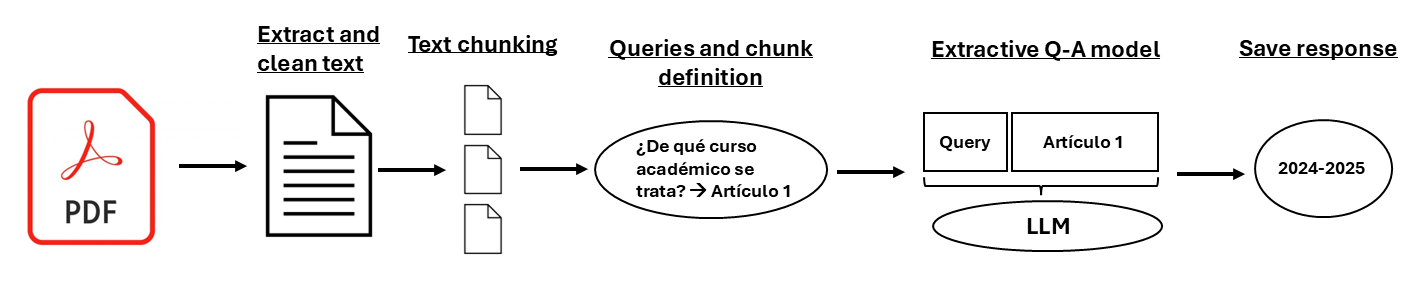

In [ ]:
import pdfplumber
import faiss
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import re

# Now we only need the QA model
qa_model = pipeline("question-answering", model="PlanTL-GOB-ES/roberta-large-bne-sqac")

# Function to obtain the response from the indicated chunk
def extract_info_from_article(question, article_text):
  response = qa_model(question=question, context=article_text)
  return response["answer"] if "answer" in response else "No encontrado"

def process_pdf(pdf_path, output_csv):
  # Extract the different articles from the PDF
  articulos = extract_articulos_to_dict(pdf_path)

  # Map: each question is associated with each articulo
  article_mapping = {
        "Año académico": "Artículo 1",
        "Financiación total": "Artículo 2",
        "Niveles no universitarios": "Artículo 3",
        "Niveles universitarios": "Artículo 3",
        "Casos especiales": "Artículo 13",
        "Cuantías fijas": "Artículo 4",
        "Cuantía fija renta": "Artículo 11",
        "Cuantía fija residencia": "Artículo 11",
        "Cuantía fija excelencia académica": "Artículo 11",
        "Cuantía variable": "Artículo 11",
        "Umbral 1": "Artículo 19",
        "Umbral 2": "Artículo 19",
        "Umbral 3": "Artículo 19",
        "Inicio plazo": "Artículo 48",
        "Deadline": "Artículo 48",
        "Requisitos año en curso": "Artículo 43",
        "Nacionalidad": "Artículo 15",
        "Número créditos matrículados": "Artículo 23",
        "Numero créditos matrícula parcial": "Artículo 23",
        "Requisitos académicos curso anterior para primer curso universitario" : "Artículo 24",
        "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": "Artículo 24"
    }

  # Define the queries
  questions = {
      "Año académico": "¿Cuál es el curso académico al que corresponde esta convocatoria de becas?",
      "Financiación total": "¿Cuál es el importe total asignado a esta convocatoria de becas?",
      "Niveles no universitarios": "¿Qué niveles de enseñanzas no universitarias están incluidos en esta convocatoria?",
      "Niveles universitarios": "¿Qué niveles de enseñanzas universitarias están cubiertos por esta convocatoria?",
      "Casos especiales": "¿Qué situaciones especiales contempla la convocatoria (como discapacidad, insularidad, etc.)?",
      "Cuantías fijas": "¿Cuáles son los diferentes tipos de cuantías fijas que cubre la beca?",
      "Cuantía fija renta": "¿Cuál es la cuantía fija establecida en función de la renta familiar?",
      "Cuantía fija residencia": "¿Cuál es la cuantía fija que se otorga por gastos de residencia?",
      "Cuantía fija excelencia académica": "¿Cuál es la cuantía fija otorgada por excelencia académica?",
      "Cuantía variable": "¿Cómo se calcula la cuantía variable de la beca y en función de qué factores?",
      "Umbral 1": "¿Cuáles son los valores del umbral 1 para la renta familiar según el número de miembros?",
      "Umbral 2": "¿Cuáles son los valores del umbral 2 para la renta familiar según el número de miembros?",
      "Umbral 3": "¿Cuáles son los valores del umbral 3 para la renta familiar según el número de miembros?",
      "Inicio plazo": "¿Desde cuándo se puede solicitar la beca?",
      "Deadline": "¿Cuál es la fecha límite para presentar la solicitud de beca?",
      "Requisitos año en curso": "¿Qué asignaturas o requisitos debe superar el alumno universitario durante el año en curso?",
      "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": "¿Qué porcentaje de créditos debe haber superado un alumno universitario en el curso anterior para renovar la beca?",
      "Requisitos académicos curso anterior para primer curso universitario": "¿Qué nota se exige en el acceso a la universidad para obtener la beca en primer curso?",
      "Nacionalidad": "¿Qué nacionalidad o condición migratoria se requiere para poder optar a la beca?",
      "Número créditos matrículados": "¿Cuántos créditos debe tener matriculados el estudiante para optar a la beca?",
      "Numero créditos matrícula parcial": "¿Cuántos créditos debe matricular el estudiante en caso de matrícula parcial?",
    }


  # Description for each field
  field_descriptions = {
      "Año académico": "Curso académico de la convocatoria.",
      "Financiación total": "Importe total asignado a la convocatoria de becas.",
      "Niveles no universitarios": "Enseñanzas no universitarias incluidas en la convocatoria.",
      "Niveles universitarios": "Enseñanzas universitarias incluidas en la convocatoria.",
      "Casos especiales": "Situaciones particulares (discapacidad, insularidad, etc.).",
      "Cuantías fijas:": "Tipos de cuantías fijas que cubre la beca.",
      "Cuantía fija renta": "Importe fijo en función de la renta familiar (en euros).",
      "Cuantía fija residencia": "Importe fijo para gastos de residencia (en euros).",
      "Cuantía fija excelencia académica": "Importe fijo por excelencia académica (en euros).",
      "Cuantía variable": "¿Cuál es el importe mínimo de la cuantía variable?.",
      "Umbral 1": "Umbral 1 de requisitos de renta familiar",
      "Umbral 2": "Umbral 2 de requisitos de renta familiar",
      "Umbral 3": "Umbral 3 de requisitos de renta familiar",
      "Inicio plazo": "Fecha desde la cual se puede presentar la solicitud",
      "Deadline": "Fecha límite para presentar la solicitud.",
      "Requisitos año en curso": "Número de asignaturas que debe superar el alumno universitario.",
      "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": "Porcentaje de créditos que debe haber superado el alumno en el curso anterior",
      "Requisitos académicos curso anterior para primer curso universitario": "Nota requerida en la nota de acceso a la universidad para estudiantes de primer curso universitario",
      "Nacionalidad": "Nacionalidad que se exige para ser beneficiario de la beca.",
      "Número créditos matrículados": "Número de créditos que debe estar matriculado el beneficiario de la beca.",
      "Numero créditos matrícula parcial": "Número de créditos que debe matricularse el beneficiario en caso de matrícula parcial.",
    }


  extracted_data = {}

  # For each field, we use the mapped articulo (if it exists)
  for field, question in questions.items():
    articulo = article_mapping.get(field, None)
    if articulo and articulo in articulos:
      context = articulos[articulo]
      answer = extract_info_from_article(question, context)
      extracted_data[field] = answer
    elif articulo == "Encabezado":
      # Si la información se extrae del encabezado, asumimos que está en "Artículo 1" o similar
      if "Artículo 1" in articulos:
        context = articulos["Artículo 1"]
        answer = extract_info_from_article(question, context)
        extracted_data[field] = answer
      else:
        extracted_data[field] = "No disponible"
    else:
      # Si no se ha definido un artículo específico para el campo (por ejemplo, Devolución)
      extracted_data[field] = "No se especifica en la convocatoria"

  # Save extracted data in a CSV file
  row_description = {field: field_descriptions.get(field, "") for field in extracted_data.keys()}
  df = pd.DataFrame([row_description, extracted_data])
  df.to_csv(output_csv, index=False)
  print(f"✅ Datos extraídos de la convocatoria guardados en {output_csv}")
  return df

Device set to use cuda:0


In [ ]:
pdf_path = "ayudas_23-24.pdf"
output_csv = "scholarship_data_second_approach.csv"
df = process_pdf(pdf_path, output_csv)
df

✅ Datos extraídos de la convocatoria guardados en scholarship_data_second_approach.csv


,Año académico,Financiación total,Niveles no universitarios,Niveles universitarios,Casos especiales,Cuantías fijas,Cuantía fija renta,Cuantía fija residencia,Cuantía fija excelencia académica,Cuantía variable,...,Umbral 2,Umbral 3,Inicio plazo,Deadline,Requisitos año en curso,Requisitos académicos curso anterior para segundo y posteriores cursos universitarios,Requisitos académicos curso anterior para primer curso universitario,Nacionalidad,Número créditos matrículados,Numero créditos matrícula parcial
0,Curso académico de la convocatoria.,Importe total asignado a la convocatoria de be...,Enseñanzas no universitarias incluidas en la c...,Enseñanzas universitarias incluidas en la conv...,"Situaciones particulares (discapacidad, insula...",,Importe fijo en función de la renta familiar (...,Importe fijo para gastos de residencia (en eur...,Importe fijo por excelencia académica (en euros).,¿Cuál es el importe mínimo de la cuantía varia...,...,Umbral 2 de requisitos de renta familiar,Umbral 3 de requisitos de renta familiar,Fecha desde la cual se puede presentar la soli...,Fecha límite para presentar la solicitud.,Número de asignaturas que debe superar el alum...,Porcentaje de créditos que debe haber superado...,Nota requerida en la nota de acceso a la unive...,Nacionalidad que se exige para ser beneficiari...,Número de créditos que debe estar matriculado ...,Número de créditos que debe matricularse el be...
1,2023-2024,"1.850.000.000,00 euros",Enseñanzas postobligatorias y superiores,Enseñanzas postobligatorias y superiores,Becas especiales para estudiantes universitari...,Beca de matrícula,"1.700,00 euros","2.500,00 euros",entre 50 y 125 euros,la nota media del expediente del estudiante y ...,...,"13.236,00 euros","14.112,00 euros",el día 27 de marzo de 2023,el 17 de mayo de 2023,el cincuenta por ciento,Porcentaje de Rama o área de conocimiento,"5,00 puntos",No estar en posesión o no reunir los requisito...,60,60


# Approach 4

### Issue with the previous approach

Previously, we used a QA model to respond to the queries. The problem is that these models are 'extractive models' aimed at providing short answers from the text to specific questions. If we want more complete or elaborated responses (such as obtain a list of possible Niveles no universitarios), this model will only provide the first, short piece of information it comes across.

To tackle this problem and obtain more complete information from the text, we will combine the already implemented QA model approach, and manual information extraction. For short and simple information that we want to extract, we will use the QA model, as it effectively finds the information and provides good answers. For lists or other kind of information the QA model struggled with, we will analyse the documents, study the patterns of the data and how it is being expressed, and define rules to extract such data automatically. Hence, we will use a hybrid approach:

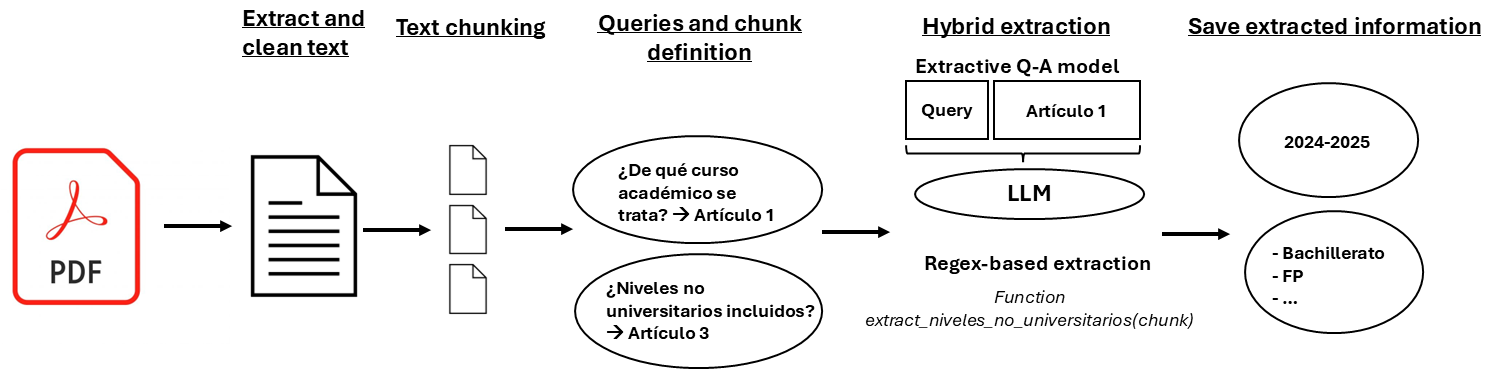

Let's define all the functions to extract the desired information manually (regex-based extraction):

In [ ]:
# Rules to extract the list of Niveles no universitarios
def extract_niveles_no_universitarios(text):
  # Pattern to find section 1 about "Enseñanzas postobligatorias y superiores no universitarias"
  pattern = r"1\.\s+Enseñanzas postobligatorias y superiores no universitarias.*?(?=2\.|$)"
  section_match = re.search(pattern, text, re.DOTALL)

  if not section_match:
      return ""  # Return empty string if no match is found

  section = section_match.group(0)

  # Pattern to extract each item (letter followed by content)
  items_pattern = r"[a-z]\)\s+(.*?)(?=(?:[a-z]\)|$))"
  items = re.findall(items_pattern, section, re.DOTALL)

  # Truncate each item at the first comma or period
  truncated_items = []
  for item in items:
      item = re.sub(r'\s+', ' ', item).strip()  # Clean up whitespace
      match = re.search(r'[.,]', item)
      if match:
          # Cut up to and including the period or comma
          truncated_items.append(item[:match.end()])
      else:
          truncated_items.append(item)

  # Convert to CSV-ready format
  csv_text = "  |  ".join(truncated_items)

  return csv_text

# Rules to extract the list of Niveles universitarios
def extract_niveles_universitarios(text):
    # Try several patterns to find section 2 about university education
    patterns = [
        r"2\.\s+Enseñanzas (?:artísticas superiores y )?enseñanzas? universitarias.*?(?=CAPÍTULO|\Z)",
        r"2\.\s+Enseñanzas universitarias.*?(?=CAPÍTULO|\Z)"
    ]

    section = ""
    for pattern in patterns:
        section_match = re.search(pattern, text, re.DOTALL)
        if section_match:
            section = section_match.group(0)
            break

    if not section:
        return ""  # Return empty string if no match is found

    # Pattern to extract each item (letter followed by content)
    items_pattern = r"[a-z]\)\s+(.*?)(?=(?:[a-z]\)|No se incluyen|$))"
    items = re.findall(items_pattern, section, re.DOTALL)

    # Truncate each item at the first comma or period
    truncated_items = []
    for item in items:
        item = re.sub(r'\s+', ' ', item).strip()  # Clean up whitespace
        match = re.search(r'[.,]', item)
        if match:
            # Cut up to and including the period or comma
            truncated_items.append(item[:match.end()])
        else:
            truncated_items.append(item)

    # Convert to CSV-ready format
    csv_text = "  |  ".join(truncated_items)

    return csv_text

# Rules to extract each field of the table describing the academic excellence scholarship
def extract_cuantia_fija_excelencia_academica(text):
  # Find the section with the academic excellence amounts
  pattern = r"Cuantía fija ligada a la excelencia académica:.*?Nota media del Cuantía en estudiante euros(.*?)(?=e\) Beca básica|$)"
  section_match = re.search(pattern, text, re.DOTALL)

  if not section_match:
    return "Section with excellence amounts not found"

  section_text = section_match.group(1).strip()

  # Extract the rows with grade ranges and amounts
  # Pattern looks for: "Entre X y Y puntos" or "X puntos o más" followed by amount
  csv_rows = []

  # Pattern for "Entre X y Y puntos Z euros"
  range_pattern = r"Entre (\d+,\d+) y (\d+,\d+) puntos (\d+) euros"
  range_matches = re.findall(range_pattern, section_text)

  for min_grade, max_grade, amount in range_matches:
    csv_rows.append(f"Entre {min_grade} y {max_grade} puntos,{amount}")

  # Pattern for "X puntos o más Z euros"
  min_pattern = r"(\d+,\d+) puntos o más (\d+) euros"
  min_matches = re.findall(min_pattern, section_text)

  for min_grade, amount in min_matches:
    csv_rows.append(f"{min_grade} puntos o más,{amount}")

  # Join rows with newlines to form CSV content
  csv_text = "  |  ".join(csv_rows)

  return csv_text


# We have 3 umbrales. Let's extract the information for each one:

def extract_umbral_table(text, umbral_column):
    # Split the text to isolate the table data
    header_split = re.split(r"a continuación:\s*", text, flags=re.IGNORECASE)
    if len(header_split) < 2:
        return None
    table_part = header_split[1].strip()

    # Split into tokens (words/numbers)
    tokens = table_part.split()

    # Map numeric family sizes to Spanish text
    size_map = {
        '1': 'un miembro',
        '2': 'dos miembros',
        '3': 'tres miembros',
        '4': 'cuatro miembros',
        '5': 'cinco miembros',
        '6': 'seis miembros',
        '7': 'siete miembros',
        '8': 'ocho miembros'
    }

    # Find the start of data rows (skip headers like "nº de miembros...")
    try:
        data_start = tokens.index("familia") + 1
    except ValueError:
        return None

    data_tokens = tokens[data_start:]

    csv_lines = []

    # Extract values for family sizes 1-8
    for i in range(0, 32, 4):  # 8 families * 4 columns each
        if i + umbral_column >= len(data_tokens):
            break

        family_size = data_tokens[i]
        amount = data_tokens[i + umbral_column].replace('.', '') + '.00'  # Format as XXXX.00

        if family_size in size_map:
            csv_lines.append(f"{size_map[family_size]},{amount}")

    # Extract additional member amount
    try:
        add_idx = data_tokens.index("Cada")
        additional_amount = data_tokens[add_idx + umbral_column + 1].replace('.', '') + '.00'
        csv_lines.append(f"adicional,{additional_amount}")
    except (ValueError, IndexError):
        pass

    return "  |  ".join(csv_lines)

# Umbral 1
def extract_umbral_1(text):
  # Pattern to extract the Umbral 1 section
  pattern = r"1\.\s+Umbral 1:(.*?)(?=2\.\s+Umbral 2:)"

  # Find the Umbral 1 section
  match = re.search(pattern, text, re.DOTALL)

  if match:
    umbral_1_text = match.group(1).strip()

    # Extract the family sizes and amounts
    family_data = re.findall(r"•\s+Familias de (.*?):\s+([\d.]+,\d+)\s+euros", umbral_1_text)

    # Extract the additional amount info
    additional = re.search(r"A partir del octavo miembro se añadirán ([\d.]+,\d+)\s+euros", umbral_1_text)
    additional_amount = additional.group(1) if additional else ""

    # Create CSV formatted text
    csv_lines = []
    for size, amount in family_data:
      csv_lines.append(f"{size},{amount.replace('.', '').replace(',', '.')}")

    # Add the additional amount as a separate entry if it exists
    if additional_amount:
      csv_lines.append(f"adicional,{additional_amount.replace('.', '').replace(',', '.')}")

    return "  |  ".join(csv_lines)

  return extract_umbral_table(text, umbral_column=1)

# Umbral 2
def extract_umbral_2(text):
  # Pattern to extract the Umbral 2 section
  pattern = r"2\.\s+Umbral 2:(.*?)(?=3\.\s+Umbral 3:)"

  # Find the Umbral 2 section
  match = re.search(pattern, text, re.DOTALL)

  if match:
    umbral_2_text = match.group(1).strip()

    # Extract the family sizes and amounts
    family_data = re.findall(r"•\s+Familias de (.*?):\s+([\d.]+,\d+)\s+euros", umbral_2_text)

    # Extract the additional amount info
    additional = re.search(r"A partir del octavo miembro se añadirán ([\d.]+,\d+)\s+euros", umbral_2_text)
    additional_amount = additional.group(1) if additional else ""

    # Create CSV formatted text
    csv_lines = []
    for size, amount in family_data:
      csv_lines.append(f"{size},{amount.replace('.', '').replace(',', '.')}")

    # Add the additional amount as a separate entry if it exists
    if additional_amount:
      csv_lines.append(f"adicional,{additional_amount.replace('.', '').replace(',', '.')}")

    return "  |  ".join(csv_lines)

  return extract_umbral_table(text, umbral_column=2)

# Umbral 3
def extract_umbral_3(text):
  # Pattern to extract the Umbral 3 section - note this needs to handle being at the end
  pattern = r"3\.\s+Umbral 3:(.*?)(?=\n\n|$)"

  # Find the Umbral 3 section
  match = re.search(pattern, text, re.DOTALL)

  if match:
    umbral_3_text = match.group(1).strip()

    # Extract the family sizes and amounts
    family_data = re.findall(r"•\s+Familias de (.*?):\s+([\d.]+,\d+)\s+euros", umbral_3_text)

    # Extract the additional amount info
    additional = re.search(r"A partir del octavo miembro se añadirán ([\d.]+,\d+)\s+euros", umbral_3_text)
    additional_amount = additional.group(1) if additional else ""

    # Create CSV formatted text
    csv_lines = []
    for size, amount in family_data:
      csv_lines.append(f"{size},{amount.replace('.', '').replace(',', '.')}")

    # Add the additional amount as a separate entry if it exists
    if additional_amount:
      csv_lines.append(f"adicional,{additional_amount.replace('.', '').replace(',', '.')}")

    return "  |  ".join(csv_lines)

  return extract_umbral_table(text, umbral_column=3)

# Function to extract nationality requirements
def extract_nationality(text):
    # Pattern to find paragraph d) and extract its first sentence (up to the first period)
    pattern = r"d\) (.*?)\."  # Capture everything between "d) " and the first period

    # Search for the pattern
    match = re.search(pattern, text)

    if match:
        return match.group(1)
    else:
        return ""

# Extract list for requisitos académicos (percentage of required passed subjects for the previous academic year)
def extract_requisitos_academicos(text):
  # First locate the section with the percentages table
  section_pattern = r"Porcentaje de Rama o área de conocimiento créditos a superar(.*?)Los estudiantes que"
  section_match = re.search(section_pattern, text, re.DOTALL)

  if not section_match:
      return ""

  section_text = section_match.group(1).strip()

  # Define a more robust pattern for extracting areas and percentages
  # This handles various formats of how the data might appear
  entries = re.findall(r"([A-ZÁÉÍÓÚáéíóú][^\.0-9]*?)[\.\s]+(\d+)%", section_text)

  csv_lines = []

  for area, percentage in entries:
    # Clean up area name (remove extra spaces, dots, etc.)
    area_clean = re.sub(r'\s+', ' ', area).strip()
    # Convert percentage to integer
    percentage_int = int(percentage)
    csv_lines.append(f"{area_clean},{percentage_int}")

  # If the above pattern didn't work, try an alternative approach
  if not csv_lines:
    # Try to extract each line and process
    lines = section_text.split('\n')
    for line in lines:
      if '%' in line:
        # Find area and percentage in this line
        percentage_match = re.search(r'(\d+)%', line)
        if percentage_match:
          percentage = int(percentage_match.group(1))
          # Extract area by removing the percentage part and cleaning
          area_part = line.split(percentage_match.group(0))[0]
          area = re.sub(r'\.+', '', area_part).strip()
          if area:
            csv_lines.append(f"{area},{percentage}")

  return "  |  ".join(csv_lines)


def extract_cuantias_fijas(text):
    # Pattern to find the section about "Cuantías fijas"
    pattern = r"1\.\s+Cuantías fijas\..*?(?=2\.|$)"
    section_match = re.search(pattern, text, re.DOTALL)

    if not section_match:
        return ""

    section = section_match.group(0)

    # Extract each item (a through e)
    items_pattern = r"[a-z]\)\s+(.*?)(?=(?:[a-z]\)|$))"
    items = re.findall(items_pattern, section, re.DOTALL)

    # Clean up each item (remove newlines and extra spaces)
    cleaned_items = []
    for item in items:
        cleaned = re.sub(r'\s+', ' ', item).strip()
        cleaned_items.append(cleaned)

    # Convert to desired format
    result = " | ".join(cleaned_items)

    return result

Once we defined the functions to extract the information for some queries, let's split all the different fields into the ones who will be answered by the QA model, and the ones who will be answered using the functions we just defined:

In [ ]:
import pdfplumber
import faiss
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import re

qa_model = pipeline("question-answering", model="PlanTL-GOB-ES/roberta-large-bne-sqac")


# Function to obtain the response from the indicated chunk
def extract_info_from_article(question, article_text):
  response = qa_model(question=question, context=article_text)
  return response["answer"] if "answer" in response else "No encontrado"


def process_pdf(pdf_path, output_csv):
  # Extract the different articles from the PDF
  articulos = extract_articulos_to_dict(pdf_path)

  # Map: each question is associated with each articulo
  article_mapping = {
      "Año académico": "Artículo 1",
      "Financiación total": "Artículo 2",
      "Niveles no universitarios": "Artículo 3",
      "Niveles universitarios": "Artículo 3",
      "Casos especiales": "Artículo 13",
      "Cuantías fijas": "Artículo 4",
      "Cuantía fija renta": "Artículo 11",
      "Cuantía fija residencia": "Artículo 11",
      "Cuantía fija excelencia académica": "Artículo 11",
      "Cuantía variable": "Artículo 11",
      "Umbral 1": "Artículo 19",
      "Umbral 2": "Artículo 19",
      "Umbral 3": "Artículo 19",
      "Inicio plazo": "Artículo 48",
      "Deadline": "Artículo 48",
      "Requisitos año en curso": "Artículo 43",
      "Nacionalidad": "Artículo 15",
      "Número créditos matrículados": "Artículo 23",
      "Numero créditos matrícula parcial": "Artículo 23",
      "Requisitos académicos curso anterior para primer curso universitario" : "Artículo 24",
      "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": "Artículo 24"
  }

  # Define the questions we want the QA model to answer
  questions = { # These are questions that can be answered with short responses, hence we can use a QA model. For larger responses we will use the manual extraction
    "Año académico": "Indica el curso académico para el que se convoca la beca.",
    "Financiación total": "Menciona la financiación total asignada a la convocatoria de becas.",
    "Casos especiales": "Indica las situaciones especiales contempladas (por ejemplo, discapacidad, familias numerosas o condiciones de insularidad).",
    "Cuantía fija renta": "¿Cuál es la cuantía fija asignada en función de la renta familiar? (valor en euros)",
    "Cuantía fija residencia": "¿Cuál es la cuantía fija destinada a cubrir gastos de residencia? (valor en euros)",
    "Cuantía variable": "¿Cuál es el importe mínimo de la cuantía variable?.",
    "Inicio plazo": "¿Desde cuándo se puede solicitar la beca?",
    "Deadline": "¿Cuál es la fecha límite para presentar la solicitud de la beca?",
    "Requisitos año en curso": "¿Cuántas asignaturas debe superar el alumno universitario para cumplir los requisitos de la beca?",
    "Número créditos matrículados": "¿Cuál es el número de créditos que deberá estar matrículado el alumno?",
    "Numero créditos matrícula parcial": "¿De entre cuántos créditos deberá matrícularse el alumno en caso de matrícula parcial?",
    "Requisitos académicos curso anterior para primer curso universitario" : "¿Cuál es la nota requerida en la nota de acceso a la universidad para estudiantes de primer curso universitario?",
  }

  # Define fields we want to extract using the defined functions
  manual_extraction = {
    "Niveles no universitarios": extract_niveles_no_universitarios,
    "Niveles universitarios": extract_niveles_universitarios,
    "Cuantías fijas": extract_cuantias_fijas,
    "Cuantía fija excelencia académica": extract_cuantia_fija_excelencia_academica,
    "Umbral 1": extract_umbral_1,
    "Umbral 2": extract_umbral_2,
    "Umbral 3": extract_umbral_3,
    "Nacionalidad": extract_nationality,
    "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": extract_requisitos_academicos,

  }

  # Description of each field
  field_descriptions = {
    "Año académico": "Curso académico de la convocatoria.",
    "Financiación total": "Importe total asignado a la convocatoria de becas.",
    "Niveles no universitarios": "Enseñanzas no universitarias incluidas en la convocatoria.",
    "Niveles universitarios": "Enseñanzas universitarias incluidas en la convocatoria.",
    "Casos especiales": "Situaciones particulares (discapacidad, insularidad, etc.).",
    "Cuantías fijas": "Tipos de cuantías fijas que cubre la beca.",
    "Cuantía fija renta": "Importe fijo en función de la renta familiar (en euros).",
    "Cuantía fija residencia": "Importe fijo para gastos de residencia (en euros).",
    "Cuantía fija excelencia académica": "Importe fijo por excelencia académica (en euros).",
    "Cuantía variable": "Importe mínimo de la cuantía variable (en euros).",
    "Umbral 1": "Umbral 1 de requisitos de renta familiar",
    "Umbral 2": "Umbral 2 de requisitos de renta familiar",
    "Umbral 3": "Umbral 3 de requisitos de renta familiar",
    "Inicio plazo": "Fecha desde la cual se puede presentar la solicitud",
    "Deadline": "Fecha límite para presentar la solicitud.",
    "Requisitos año en curso": "Número de asignaturas que debe superar el alumno universitario.",
    "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios": "Porcentaje de créditos que debe haber superado el alumno en el curso anterior según la rama",
    "Requisitos académicos curso anterior para primer curso universitario": "Nota requerida en la nota de acceso a la universidad para estudiantes de primer curso universitario",
    "Nacionalidad": "Nacionalidad que se exige para ser beneficiario de la beca.",
    "Número créditos matrículados": "Número de créditos que debe estar matriculado el beneficiario de la beca.",
    "Numero créditos matrícula parcial": "Número de créditos que debe matricularse el beneficiario en caso de matrícula parcial.",
  }


  extracted_data = {}
  # Para cada campo, se utiliza el artículo mapeado (si existe)
  for field, question in questions.items():
    articulo = article_mapping.get(field, None)
    if articulo and articulo in articulos:
      context = articulos[articulo]
      answer = extract_info_from_article(question, context)
      extracted_data[field] = answer
    elif articulo == "Encabezado":
      # Si la información se extrae del encabezado, asumimos que está en "Artículo 1" o similar
      if "Artículo 1" in articulos:
        context = articulos["Artículo 1"]
        answer = extract_info_from_article(question, context)
        extracted_data[field] = answer
      else:
        extracted_data[field] = "No disponible"
    else:
      # Si no se ha definido un artículo específico para el campo (por ejemplo, Devolución)
      extracted_data[field] = "No se especifica en la convocatoria"

  # And now the rule-based extraction
  for field, function in manual_extraction.items():
    articulo = article_mapping.get(field, None)
    if articulo and articulo in articulos:
      extracted_data[field] = function(articulos[articulo])


  # Save the extracted data in a CSV file
  row_description = {field: field_descriptions.get(field, "") for field in extracted_data.keys()}
  df = pd.DataFrame([row_description, extracted_data])
  df.to_csv(output_csv, index=False)
  print(f"✅ Datos extraídos de la convocatoria guardados en {output_csv}")
  return df

Device set to use cuda:0


# Evaluation of the final approach


Now, let's check that our hybrid approach works well across all the files in the corpus:

In [ ]:
import logging
logging.getLogger('pdfminer').setLevel(logging.ERROR)  # Only show errors, not warnings

pdf_path = "ayudas_21-22.pdf"
output_csv = "21-22.csv"
df = process_pdf(pdf_path, output_csv)
df

✅ Datos extraídos de la convocatoria guardados en 21-22.csv


,Año académico,Financiación total,Casos especiales,Cuantía fija renta,Cuantía fija residencia,Cuantía variable,Inicio plazo,Deadline,Requisitos año en curso,Número créditos matrículados,...,Requisitos académicos curso anterior para primer curso universitario,Niveles no universitarios,Niveles universitarios,Cuantías fijas,Cuantía fija excelencia académica,Umbral 1,Umbral 2,Umbral 3,Nacionalidad,Requisitos académicos curso anterior para segundo y posteriores cursos universitarios
0,Curso académico de la convocatoria.,Importe total asignado a la convocatoria de be...,"Situaciones particulares (discapacidad, insula...",Importe fijo en función de la renta familiar (...,Importe fijo para gastos de residencia (en eur...,Importe mínimo de la cuantía variable (en euros).,Fecha desde la cual se puede presentar la soli...,Fecha límite para presentar la solicitud.,Número de asignaturas que debe superar el alum...,Número de créditos que debe estar matriculado ...,...,Nota requerida en la nota de acceso a la unive...,Enseñanzas no universitarias incluidas en la c...,Enseñanzas universitarias incluidas en la conv...,Tipos de cuantías fijas que cubre la beca.,Importe fijo por excelencia académica (en euros).,Umbral 1 de requisitos de renta familiar,Umbral 2 de requisitos de renta familiar,Umbral 3 de requisitos de renta familiar,Nacionalidad que se exige para ser beneficiari...,Porcentaje de créditos que debe haber superado...
1,2021-2022,crédito 18.08.323M.482.00,Becas especiales para estudiantes universitari...,"1.700,00 euros","1.600,00 euros","60,00 euros",28/07/2021,"El 14 de octubre de 2021, inclusive, para los ...",el cincuenta por ciento,60,...,"5,00 puntos",Primer y segundo cursos de bachillerato. | F...,Enseñanzas universitarias conducentes a título...,Beca de matrícula. | Cuantía fija ligada a la ...,Section with excellence amounts not found,"un miembro,8422.00 | dos miembros,12632.00 ...","un miembro,13236.00 | dos miembros,22594.00 ...","un miembro,14112.00 | dos miembros,24089.00 ...",Ser español o poseer la nacionalidad de un Est...,"Artes y Humanidades,90 | Ciencias,65 | Cie..."


In [ ]:
pdf_path = "ayudas_22-23.pdf"
output_csv = "22-23.csv"
df = process_pdf(pdf_path, output_csv)
df

✅ Datos extraídos de la convocatoria guardados en 22-23.csv


,Año académico,Financiación total,Casos especiales,Cuantía fija renta,Cuantía fija residencia,Cuantía variable,Inicio plazo,Deadline,Requisitos año en curso,Número créditos matrículados,...,Requisitos académicos curso anterior para primer curso universitario,Niveles no universitarios,Niveles universitarios,Cuantías fijas,Cuantía fija excelencia académica,Umbral 1,Umbral 2,Umbral 3,Nacionalidad,Requisitos académicos curso anterior para segundo y posteriores cursos universitarios
0,Curso académico de la convocatoria.,Importe total asignado a la convocatoria de be...,"Situaciones particulares (discapacidad, insula...",Importe fijo en función de la renta familiar (...,Importe fijo para gastos de residencia (en eur...,Importe mínimo de la cuantía variable (en euros).,Fecha desde la cual se puede presentar la soli...,Fecha límite para presentar la solicitud.,Número de asignaturas que debe superar el alum...,Número de créditos que debe estar matriculado ...,...,Nota requerida en la nota de acceso a la unive...,Enseñanzas no universitarias incluidas en la c...,Enseñanzas universitarias incluidas en la conv...,Tipos de cuantías fijas que cubre la beca.,Importe fijo por excelencia académica (en euros).,Umbral 1 de requisitos de renta familiar,Umbral 2 de requisitos de renta familiar,Umbral 3 de requisitos de renta familiar,Nacionalidad que se exige para ser beneficiari...,Porcentaje de créditos que debe haber superado...
1,2022-2023,crédito 18.08.323M.482.00,Becas especiales para estudiantes universitari...,"1.700,00 euros","60,00 euros","60,00 euros",el día 30 de marzo de 2022,el 12 de mayo de 2022,el cincuenta por ciento,60,...,"5,00 puntos",Primer y segundo cursos de bachillerato. | F...,Enseñanzas universitarias conducentes a título...,Beca de matrícula. | Cuantía fija ligada a la ...,"Entre 8,00 y 8,49 puntos,50 | Entre 8,50 y 8...","un miembro,8422.00 | dos miembros,12632.00 ...","un miembro,13236.00 | dos miembros,22594.00 ...","un miembro,14112.00 | dos miembros,24089.00 ...",Ser español o poseer la nacionalidad de un Est...,"Artes y Humanidades,90 | Ciencias,65 | Cie..."


In [ ]:
pdf_path = "ayudas_23-24.pdf"
output_csv = "23-24.csv"
df = process_pdf(pdf_path, output_csv)
df

✅ Datos extraídos de la convocatoria guardados en 23-24.csv


,Año académico,Financiación total,Casos especiales,Cuantía fija renta,Cuantía fija residencia,Cuantía variable,Inicio plazo,Deadline,Requisitos año en curso,Número créditos matrículados,...,Requisitos académicos curso anterior para primer curso universitario,Niveles no universitarios,Niveles universitarios,Cuantías fijas,Cuantía fija excelencia académica,Umbral 1,Umbral 2,Umbral 3,Nacionalidad,Requisitos académicos curso anterior para segundo y posteriores cursos universitarios
0,Curso académico de la convocatoria.,Importe total asignado a la convocatoria de be...,"Situaciones particulares (discapacidad, insula...",Importe fijo en función de la renta familiar (...,Importe fijo para gastos de residencia (en eur...,Importe mínimo de la cuantía variable (en euros).,Fecha desde la cual se puede presentar la soli...,Fecha límite para presentar la solicitud.,Número de asignaturas que debe superar el alum...,Número de créditos que debe estar matriculado ...,...,Nota requerida en la nota de acceso a la unive...,Enseñanzas no universitarias incluidas en la c...,Enseñanzas universitarias incluidas en la conv...,Tipos de cuantías fijas que cubre la beca.,Importe fijo por excelencia académica (en euros).,Umbral 1 de requisitos de renta familiar,Umbral 2 de requisitos de renta familiar,Umbral 3 de requisitos de renta familiar,Nacionalidad que se exige para ser beneficiari...,Porcentaje de créditos que debe haber superado...
1,2023-2024,18.08.323M.482.00,Becas especiales para estudiantes universitari...,"1.700,00 euros","2.500,00 euros","60,00 euros",el día 27 de marzo de 2023,el 17 de mayo de 2023,el cincuenta por ciento,60,...,"5,00 puntos",Primer y segundo cursos de bachillerato. | F...,Enseñanzas universitarias conducentes a título...,Beca de matrícula. | Cuantía fija ligada a la ...,"Entre 8,00 y 8,49 puntos,50 | Entre 8,50 y 8...","un miembro,8422.00 | dos miembros,12632.00 ...","un miembro,13236.00 | dos miembros,22594.00 ...","un miembro,14112.00 | dos miembros,24089.00 ...",Ser español o poseer la nacionalidad de un Est...,"Artes y Humanidades,90 | Ciencias,65 | Cie..."


In [ ]:
pdf_path = "ayudas_24-25.pdf"
output_csv = "24-25.csv"
df = process_pdf(pdf_path, output_csv)
df

✅ Datos extraídos de la convocatoria guardados en 24-25.csv


,Año académico,Financiación total,Casos especiales,Cuantía fija renta,Cuantía fija residencia,Cuantía variable,Inicio plazo,Deadline,Requisitos año en curso,Número créditos matrículados,...,Requisitos académicos curso anterior para primer curso universitario,Niveles no universitarios,Niveles universitarios,Cuantías fijas,Cuantía fija excelencia académica,Umbral 1,Umbral 2,Umbral 3,Nacionalidad,Requisitos académicos curso anterior para segundo y posteriores cursos universitarios
0,Curso académico de la convocatoria.,Importe total asignado a la convocatoria de be...,"Situaciones particulares (discapacidad, insula...",Importe fijo en función de la renta familiar (...,Importe fijo para gastos de residencia (en eur...,Importe mínimo de la cuantía variable (en euros).,Fecha desde la cual se puede presentar la soli...,Fecha límite para presentar la solicitud.,Número de asignaturas que debe superar el alum...,Número de créditos que debe estar matriculado ...,...,Nota requerida en la nota de acceso a la unive...,Enseñanzas no universitarias incluidas en la c...,Enseñanzas universitarias incluidas en la conv...,Tipos de cuantías fijas que cubre la beca.,Importe fijo por excelencia académica (en euros).,Umbral 1 de requisitos de renta familiar,Umbral 2 de requisitos de renta familiar,Umbral 3 de requisitos de renta familiar,Nacionalidad que se exige para ser beneficiari...,Porcentaje de créditos que debe haber superado...
1,2024-2025,18.08.323M.482.00,Becas especiales para estudiantes universitari...,"1.700,00 euros","2.500,00 euros","60,00 euros",el día 19 de marzo de 2024,el 10 de mayo de 2024,el cincuenta por ciento,60,...,"5,00 puntos",Primer y segundo cursos de bachillerato. | C...,Enseñanzas universitarias conducentes a título...,Beca de matrícula. | Cuantía fija ligada a la ...,"Entre 8,00 y 8,49 puntos,50 | Entre 8,50 y 8...","un miembro,8843.00 | dos miembros,13264.00 ...","un miembro,13898.00 | dos miembros,23724.00 ...","un miembro,14818.00 | dos miembros,25293.00 ...",Ser español o poseer la nacionalidad de un Est...,"Artes y Humanidades,90 | Ciencias,65 | Cie..."


In [ ]:
pdf_path = "ayudas_25-26.pdf"
output_csv = "25-26.csv"
df = process_pdf(pdf_path, output_csv)
df

✅ Datos extraídos de la convocatoria guardados en 25-26.csv


,Año académico,Financiación total,Casos especiales,Cuantía fija renta,Cuantía fija residencia,Cuantía variable,Inicio plazo,Deadline,Requisitos año en curso,Número créditos matrículados,...,Requisitos académicos curso anterior para primer curso universitario,Niveles no universitarios,Niveles universitarios,Cuantías fijas,Cuantía fija excelencia académica,Umbral 1,Umbral 2,Umbral 3,Nacionalidad,Requisitos académicos curso anterior para segundo y posteriores cursos universitarios
0,Curso académico de la convocatoria.,Importe total asignado a la convocatoria de be...,"Situaciones particulares (discapacidad, insula...",Importe fijo en función de la renta familiar (...,Importe fijo para gastos de residencia (en eur...,Importe mínimo de la cuantía variable (en euros).,Fecha desde la cual se puede presentar la soli...,Fecha límite para presentar la solicitud.,Número de asignaturas que debe superar el alum...,Número de créditos que debe estar matriculado ...,...,Nota requerida en la nota de acceso a la unive...,Enseñanzas no universitarias incluidas en la c...,Enseñanzas universitarias incluidas en la conv...,Tipos de cuantías fijas que cubre la beca.,Importe fijo por excelencia académica (en euros).,Umbral 1 de requisitos de renta familiar,Umbral 2 de requisitos de renta familiar,Umbral 3 de requisitos de renta familiar,Nacionalidad que se exige para ser beneficiari...,Porcentaje de créditos que debe haber superado...
1,2025-2026,18.08.323M.482.00,Becas especiales para estudiantes universitari...,"1.700,00 euros","2.700,00 euros","60,00 euros",el día 24 de marzo de 2025,el 14 de mayo de 2025,el cincuenta por ciento,60,...,"5,00 puntos",Primer y segundo cursos de bachillerato. | C...,Enseñanzas artísticas superiores. | Enseñanz...,Beca de matrícula. | Cuantía fija ligada a la ...,"Entre 8,00 y 8,49 puntos,50 | Entre 8,50 y 8...","un miembro,8843.00 | dos miembros,13264.00 ...","un miembro,13898.00 | dos miembros,23724.00 ...","un miembro,14818.00 | dos miembros,25293.00 ...",Ser español o poseer la nacionalidad de un Est...,"Artes y Humanidades,90 | Ciencias,65 | Cie..."


# Summary generation from the CSV file:

In [ ]:
from transformers import pipeline
# T5 model
t5_generator = pipeline("text2text-generation", model="flan-t5-large")

# BART model
bart_generator = pipeline("text2text-generation", model="facebook/bart-large-cnn")

# Optionally, Pegasus model
pegasus_generator = pipeline("text2text-generation", model="google/pegasus-xsum")

In [ ]:
import pandas as pd

df = pd.read_csv("21-22.csv")

# Combine label and value rows
data_dict = {df.columns[i]: f"{df.iloc[0, i]} — {df.iloc[1, i]}" for i in range(len(df.columns))}
context = "\n".join([f"{key}: {value}" for key, value in data_dict.items()])

# Assuming you want to re-read the CSV:
df = pd.read_csv("21-22.csv") # Changed pd.read to pd.read_csv

print(context)

Año académico: Curso académico de la convocatoria. — 2021-2022
Financiación total: Importe total asignado a la convocatoria de becas. — crédito 18.08.323M.482.00
Casos especiales: Situaciones particulares (discapacidad, insularidad, etc.). — Becas especiales para estudiantes universitarios con discapacidad
Cuantía fija renta: Importe fijo en función de la renta familiar (en euros). — 1.700,00 euros
Cuantía fija residencia: Importe fijo para gastos de residencia (en euros). — 1.600,00 euros
Cuantía variable: Importe mínimo de la cuantía variable (en euros). — 60,00 euros
Inicio plazo: Fecha desde la cual se puede presentar la solicitud — 28/07/2021
Deadline: Fecha límite para presentar la solicitud. — El 14 de octubre de 2021, inclusive, para los estudiantes universitarios
Requisitos año en curso: Número de asignaturas que debe superar el alumno universitario. — el cincuenta por ciento
Número créditos matrículados: Número de créditos que debe estar matriculado el beneficiario de la beca

In [ ]:
prompt = f"""Genera un resumen que incluya de forma explícita todos los siguientes datos de la convocatoria de becas:

{context[:401]}

El resumen debe mencionar y explicar cada uno de los campos anteriores de manera clara y concisa."""

print(prompt)

Genera un resumen que incluya de forma explícita todos los siguientes datos de la convocatoria de becas:

Año académico: Curso académico de la convocatoria. — 2021-2022
Financiación total: Importe total asignado a la convocatoria de becas. — crédito 18.08.323M.482.00
Casos especiales: Situaciones particulares (discapacidad, insularidad, etc.). — Becas especiales para estudiantes universitarios con discapacidad
Cuantía fija renta: Importe fijo en función de la renta familiar (en euros). — 1.700,00 euros

El resumen debe mencionar y explicar cada uno de los campos anteriores de manera clara y concisa.


In [ ]:
summary = t5_generator(prompt, max_length=400)[0]['generated_text']
print("Generated Summary:\n", summary)

Generated Summary:
 — 2021-2022 Financiación total asignado a la convocatoria de becas. — crédito 18.08.323M.482.00 Casos especiales: Situaciones particulares (discapacidad, insularidad, etc.). — Becas especiales para estudiantes universitarios con discapacidad.


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
prompt = (
    "Genera un resumen que incluya de forma explícita todos los siguientes datos de la convocatoria de becas:\n"
    "Año académico: 2021-2022\n"
    "Financiación total: crédito 18.08.323M.482.00\n"
    "Casos especiales: Becas especiales para estudiantes universitarios con discapacidad\n"
    "Cuantía fija renta: 1.700,00 euros\n"
    "Cuantía fija residencia: 1.600,00 euros\n"
    "Cuantía variable: 60,00 euros\n"
    "Inicio plazo: 28/07/2021\n"
    "Deadline: El 14 de octubre de 2021, inclusive, para los estudiantes universitarios\n"
    "Requisitos año en curso: el cincuenta por ciento\n"
    "Número créditos matrículados: 60\n"
    "Numero créditos matrícula parcial: en el segundo cuatrimestre/semestre correspondiente al curso académico\n"
    "Requisitos académicos curso anterior para primer curso universitario: 5,00 puntos\n"
    "Niveles no universitarios: Primer y segundo cursos de bachillerato, Formación Profesional de grado medio y de grado superior, "
    "Enseñanzas artísticas profesionales, Enseñanzas deportivas, Enseñanzas artísticas superiores, Estudios religiosos superiores, "
    "Estudios de idiomas realizados en escuelas oficiales de titularidad de las administraciones educativas, "
    "Cursos de acceso y cursos de preparación para las pruebas de acceso a la formación profesional y cursos de formación específicos para el acceso a los ciclos formativos de grado medio y de grado superior impartidos en centros públicos y en centros privados concertados, Ciclos Formativos de Grado Básico\n"
    "Niveles universitarios: Enseñanzas universitarias conducentes a títulos oficiales de grado y de máster, Curso de preparación para acceso a la universidad de mayores de 25 años impartido por universidades públicas, Complementos de formación para acceso u obtención del título de máster y créditos complementarios para la obtención del título de grado\n"
    "Cuantías fijas: Beca de matrícula, Cuantía fija ligada a la renta del estudiante, Cuantía fija ligada a la residencia durante el curso, "
    "Cuantía fija por excelencia en el rendimiento académico, Beca básica\n"
    "Cuantía fija excelencia académica: Section with excellence amounts not found\n"
    "Umbral 1: un miembro,8422.00  |  dos miembros,12632.00  |  tres miembros,16843.00  |  cuatro miembros,21054.00  |  cinco miembros,24423.00  |  seis miembros,27791.00  |  siete miembros,31160.00  |  ocho miembros,34529.00  |  adicional,3368.00\n"
    "Umbral 2: un miembro,13236.00  |  dos miembros,22594.00  |  tres miembros,30668.00  |  cuatro miembros,36421.00  |  cinco miembros,40708.00  |  seis miembros,43945.00  |  siete miembros,47146.00  |  ocho miembros,50333.00  |  adicional,3181.00\n"
    "Umbral 3: un miembro,14112.00  |  dos miembros,24089.00  |  tres miembros,32697.00  |  cuatro miembros,38831.00  |  cinco miembros,43402.00  |  seis miembros,46853.00  |  siete miembros,50267.00  |  ocho miembros,53665.00  |  adicional,3391.00\n"
    "Nacionalidad: Ser español o poseer la nacionalidad de un Estado miembro de la Unión Europea\n"
    "Requisitos académicos curso anterior para segundo y posteriores cursos universitarios: "
    "Artes y Humanidades,90  |  Ciencias,65  |  Ciencias Sociales y Jurídicas,90  |  Ciencias de la Salud,80  |  Ingeniería o Arquitectura/ enseñanzas técnicas,65\n"
    "\n"
    "Resume estos datos en un texto final que integre y explique cada uno de los campos de la convocatoria de becas."
)


In [ ]:
# Import necessary libraries if not already imported.
import torch

# Tokenize the input prompt.
inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

# Generate the output.
# You can adjust max_length, temperature, top_p, etc., to tweak generation behavior.
outputs = model.generate(
    **inputs,
    max_length=500,   # Ensure this is large enough for your summary
    num_beams=5,      # Beam search for more coherent output
    early_stopping=True
)

# Decode the output tokens to a string.
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated Summary:\n", summary)


Generated Summary:
 Genera un resumen que incluya de forma explcita todos los siguientes datos de la convocatoria de becas: Ao académico: 2021-2022 Financiación total: crédito 18.08.323M.482.00 Casos especiales: Becas especiales para estudiantes universitarios con discapacidad Cuanta fija renta: 1.700,00 euros Cuanta fija residencia: 1.600,00 euros Cuanta variable: 60,00 euros Inicio plazo: 28/07/2021 Deadline: El 14 de octubre de 2021, inclusive, para los estudiantes universitarios Requisitos académicos ao en curso: el cincuenta por ciento Nmero de créditos matrculados: 60 Numero de créditos matrcula parcial: en el segundo cuatrimestre/semestre correspondiente al curso académico Requisitos académicos curso anterior para primer curso universitario: 5.000 puntos Niveles no universitarios: Primer y segundo cursos de bachillerato, Formación Profesional de grado medio y de grado superior, Enseanzas profesionales artsticas profesionales, Enseanzas deportivas, Enseanzas artsticas superiores,